## TP4 - Accélération du code BEM pour l’équation de Helmholtz 2D : Étape 1 clustering

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import graphviz  # Importé pour le tracé de l'arbre

### Classe Noeud

In [11]:
class noeudArbre:
    """
    Représente un nœud dans l'arbre de partitionnement binaire de l'espace (BSP).
    """
    def __init__(self):
        self.gauche = None       # Enfant gauche
        self.droit = None        # Enfant droit
        self.est_feuille = False
        self.points = None       # Points contenus dans ce nœud (si feuille)
        self.boite = None        # Boîte englobante (min_coords, max_coords)
        self.axe_division = None # Axe de division (0 pour x, 1 pour y, ...)
        self.coord_division = None # Coordonnée de la division
        self.profondeur = 0

### Diamètre boite

In [12]:
def calculer_diametre_boite(boite):
    """Calcule le diamètre (diagonale) d'une boîte englobante."""
    if boite is None:
        return 0.0
    min_coords, max_coords = boite
    etendues = max_coords - min_coords
    dist_sq = np.sum(etendues**2)
    return np.sqrt(dist_sq)

### Distance entre boites

In [13]:
def distance_entre_boites(boite_A, boite_B):
    """
    Calcule la distance entre les faces les plus proches de deux boîtes
    (implémentation de la formule dist_box(X, Y)).
    
    C'est une BORNE INFÉRIEURE de la distance entre les points.
    """
    if boite_A is None or boite_B is None:
        return np.inf # Pas de distance définissable

    min_A, max_A = boite_A
    min_B, max_B = boite_B
    
    # La formule est complexe, mais elle se simplifie :
    # 1. Trouver la distance sur chaque axe.
    # 2. Si les boîtes se chevauchent sur un axe, la distance est 0 pour cet axe.
    # 3. Sinon, c'est l'écart entre elles.
    
    # Terme 1: max(0, min_A - max_B)  (Cas où A est à droite de B)
    term1 = np.maximum(0, min_A - max_B)
    
    # Terme 2: max(0, min_B - max_A)  (Cas où A est à gauche de B)
    term2 = np.maximum(0, min_B - max_A)
    
    # La distance sur chaque axe est la somme de ces deux termes
    # (un seul peut être non-nul à la fois pour un axe donné)
    delta_axes = term1**2 + term**2
    
    # 4. Combiner les distances axiales avec Pythagore
    dist_sq = np.sum(delta_axes)
    return np.sqrt(dist_sq)

### Construction de l'arbre

In [14]:
def construire_arbre_bsp(points, Nleaf=5, profondeur=0):
    """
    Construit récursivement l'arbre binaire de partitionnement.

    Args:
        points (np.ndarray): Un tableau (N, D) de N points en D dimensions.
        Nleaf (int): Le nombre maximum de points dans un nœud feuille.
        profondeur (int): La profondeur actuelle de la récursion.

    Returns:
        noeudArbre: Le nœud racine de l'arbre (ou sous-arbre) construit.
    """
    noeud = noeudArbre()
    noeud.profondeur = profondeur

    # Cas de base : si peu de points, ce nœud devient une feuille
    if len(points) <= Nleaf:
        noeud.est_feuille = True
        noeud.points = points
        # Calculer la boîte englobante même pour la feuille
        if len(points) > 0:
            noeud.boite = (np.min(points, axis=0), np.max(points, axis=0))
            noeud.diam_boite_precalcule = calculer_diametre_boite(noeud.boite)
        return noeud

    # 1. Calculer la boîte englobante (BBox) chaque vecteur de longueur d
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    noeud.boite = (min_coords, max_coords)

    # Pré-calculer le diamètre de la boîte
    noeud.diam_boite_precalcule = calculer_diametre_boite(noeud.boite)

    # 2. Trouver l'axe le plus long
    etendues = max_coords - min_coords
    noeud.axe_division = np.argmax(etendues)
    
    # 3. Déterminer la coordonnée de division (basée sur la MÉDIANE)
    # On extrait les coordonnées de tous les points sur l'axe de division
    coords_sur_axe = points[:, noeud.axe_division]
    
    # On cherche l'index du point médian (N / 2)
    # C'est beaucoup plus robuste que np.median() en cas de valeurs dupliquées
    n_points = len(points)
    idx_median = n_points // 2
    
    # np.argpartition trouve les indices qui *mettraient* l'élément
    # à `idx_median` à sa place correcte s'il était trié.
    # C'est plus rapide qu'un tri complet, ça tri les indices.
    indices_tries_partiellement = np.argpartition(coords_sur_axe, idx_median)
    
    # L'index du point pivot (médian) dans le tableau d'origine
    idx_pivot_original = indices_tries_partiellement[idx_median]
    
    # La coordonnée de division est la valeur de ce point pivot
    noeud.coord_division = points[idx_pivot_original, noeud.axe_division]

    # 4. Partitionner les points
    # Nous utilisons les indices déjà partitionnés pour garantir un partage 50/50
    # Tous les points avec un index < idx_median
    indices_gauche = indices_tries_partiellement[:idx_median]
    
    # Tous les points avec un index >= idx_median (inclut le pivot)
    indices_droit = indices_tries_partiellement[idx_median:]
    
    points_gauche = points[indices_gauche]
    points_droit = points[indices_droit]

    # L'ancienne méthode (géométrique) est remplacée :
    # noeud.coord_division = min_coords[noeud.axe_division] + etendues[noeud.axe_division] / 2.0
    # masque_gauche = points[:, noeud.axe_division] < noeud.coord_division
    # points_gauche = points[masque_gauche]
    # points_droit = points[~masque_gauche] 

    # Gestion d'un cas problématique :
    # Si tous les points sont sur un côté (ex: points identiques, points alignés),
    # la récursion pourrait être infinie ou déséquilibrée.
    # On force ce nœud à devenir une feuille s'il n'y a pas de division possible.
    if len(points_gauche) == 0 or len(points_droit) == 0:
        noeud.est_feuille = True
        noeud.points = points
        return noeud

    # 5. Appel récursif pour les enfants
    noeud.gauche = construire_arbre_bsp(points_gauche, Nleaf, profondeur + 1)
    noeud.droit = construire_arbre_bsp(points_droit, Nleaf, profondeur + 1)

    return noeud

def get_max_profondeur(noeud):
    """Calcule la profondeur maximale de l'arbre."""
    if noeud is None or noeud.est_feuille:
        return noeud.profondeur if noeud else 0
    
    # Gère le cas où un enfant n'existe pas (même si ce n'est pas une feuille)
    # Bien que l'algo crée toujours 2 enfants ou une feuille.
    prof_gauche = get_max_profondeur(noeud.gauche) if noeud.gauche else noeud.profondeur
    prof_droit = get_max_profondeur(noeud.droit) if noeud.droit else noeud.profondeur
    
    return max(prof_gauche, prof_droit)

### Tracé de la partition et de l'arbre (format png)

In [15]:
def tracer_partitions(ax, noeud, x_min, x_max, y_min, y_max, cmap, max_prof):
    """
    Fonction récursive pour tracer les partitions.
    La couleur de la ligne dépend de la profondeur du nœud.
    """
    if noeud.est_feuille:
        return

    # Normaliser la profondeur pour la carte de couleur (0.0 à 1.0)
    profondeur_norm = noeud.profondeur / max_prof if max_prof > 0 else 0
    couleur = cmap(profondeur_norm)
    
    axe = noeud.axe_division
    coord = noeud.coord_division

    if axe == 0: # Division verticale (sur l'axe X)
        # Ligne '--' pour l'axe X
        ax.plot([coord, coord], [y_min, y_max], 
                color=couleur, linestyle='--', linewidth=2)
        
        tracer_partitions(ax, noeud.gauche, x_min, coord, y_min, y_max, cmap, max_prof)
        tracer_partitions(ax, noeud.droit, coord, x_max, y_min, y_max, cmap, max_prof)
        
    elif axe == 1: # Division horizontale (sur l'axe Y)
        # Ligne ':' pour l'axe Y
        ax.plot([x_min, x_max], [coord, coord], 
                color=couleur, linestyle=':', linewidth=2)

        tracer_partitions(ax, noeud.gauche, x_min, x_max, y_min, coord, cmap, max_prof)
        tracer_partitions(ax, noeud.droit, x_min, x_max, coord, y_max, cmap, max_prof)

def ajouter_noeuds_graphviz(dot, noeud):
    """Fonction helper récursive pour construire le graphe Graphviz."""
    if noeud is None:
        return
    
    node_id = str(id(noeud))
    
    if noeud.est_feuille:
        # Nœud feuille : forme de boîte, couleur grise
        label = f"Feuille\n{len(noeud.points)} points\nProf: {noeud.profondeur}"
        dot.node(node_id, label=label, shape='box', style='filled', color='lightgray')
    else:
        # Nœud de division : forme d'ellipse
        axe_str = 'X' if noeud.axe_division == 0 else 'Y'
        label = f"Axe: {axe_str}\nVal: {noeud.coord_division:.2f}\nProf: {noeud.profondeur}"
        dot.node(node_id, label=label, shape='ellipse')
    
    if noeud.gauche:
        left_id = str(id(noeud.gauche))
        dot.edge(node_id, left_id, label='<') # Points < à la coordonnée
        ajouter_noeuds_graphviz(dot, noeud.gauche)
        
    if noeud.droit:
        right_id = str(id(noeud.droit))
        dot.edge(node_id, right_id, label='>=') # Points >= à la coordonnée
        ajouter_noeuds_graphviz(dot, noeud.droit)

def tracer_arbre_graphviz(racine, nom_fichier='arbre_bsp'):
    """
    Construit et affiche l'arbre binaire en utilisant Graphviz.
    """
    dot = graphviz.Digraph(comment='Arbre de Partitionnement BSP')
    dot.attr(nodesep='0.5', ranksep='1') # Un peu plus d'espace
    
    ajouter_noeuds_graphviz(dot, racine)
    
    try:
        # Génère un fichier PNG et tente de l'ouvrir
        dot.render(nom_fichier, view=True, format='png', cleanup=True)
        print(f"\nL'arbre a été sauvegardé et affiché (fichier: {nom_fichier}.png)")
    except Exception as e:
        print(f"\nErreur avec Graphviz : {e}")
        print("Graphviz doit être installé ET ajouté au PATH de votre système.")
        print("Affichage du code source DOT à la place :\n")
        print(dot.source)

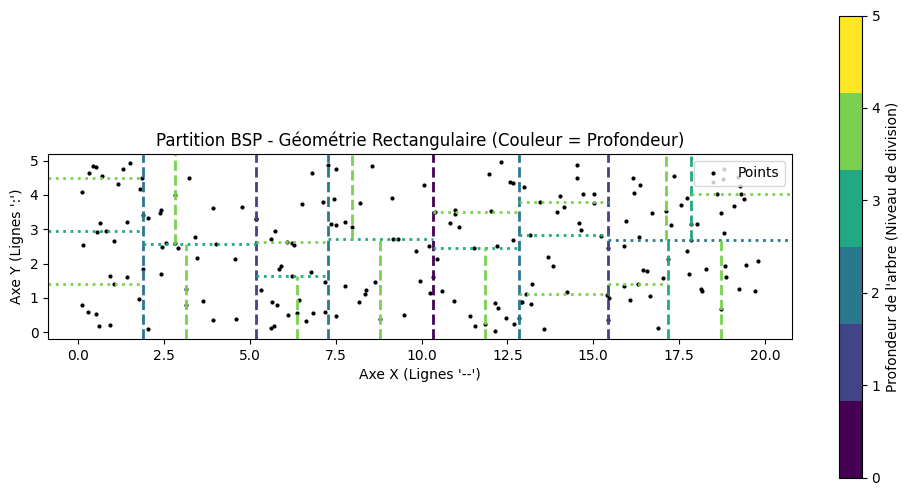


--- Génération du tracé de l'arbre ---

L'arbre a été sauvegardé et affiché (fichier: arbre_bsp_simple.png)


In [16]:
# 1. Générer les géométries
np.random.seed(42) # Pour des résultats reproductibles
nombre_points = 200

# Géométrie 1 : Nuage de points "rectangulaire" (plus long en X)
points_rect = np.random.rand(nombre_points, 2)
points_rect[:, 0] *= 20
points_rect[:, 1] *= 5

# --- Tracé pour la Géométrie Rectangulaire (avec profondeur) ---

max_points_feuille = 10
racine_rect = construire_arbre_bsp(points_rect, Nleaf=max_points_feuille)

# 2. Calculer la profondeur max et préparer la carte de couleurs
max_prof = get_max_profondeur(racine_rect)
cmap = plt.get_cmap('viridis', max_prof + 1) # Carte de couleur 'viridis'

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(points_rect[:, 0], points_rect[:, 1], 'k.', markersize=4, label='Points')

min_tot, max_tot = racine_rect.boite
padding_x = (max_tot[0] - min_tot[0]) * 0.05
padding_y = (max_tot[1] - min_tot[1]) * 0.05
x_min_plot, x_max_plot = min_tot[0] - padding_x, max_tot[0] + padding_x
y_min_plot, y_max_plot = min_tot[1] - padding_y, max_tot[1] + padding_y

# 4. Tracer les partitions avec les couleurs
tracer_partitions(ax, racine_rect, x_min_plot, x_max_plot, y_min_plot, y_max_plot, cmap, max_prof)

ax.set_title(f"Partition BSP - Géométrie Rectangulaire (Couleur = Profondeur)")
ax.set_xlabel("Axe X (Lignes '--')")
ax.set_ylabel("Axe Y (Lignes ':')")
ax.set_aspect('equal')
ax.set_xlim(x_min_plot, x_max_plot)
ax.set_ylim(y_min_plot, y_max_plot)

# 5. Ajouter la barre de couleur (Colorbar)
norm = plt.Normalize(vmin=0, vmax=max_prof)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=range(max_prof + 1))
cbar.set_label('Profondeur de l\'arbre (Niveau de division)')

plt.legend(loc='upper right')
plt.show()

# --- Tracé de l'arbre lui-même (avec un exemple plus simple) ---

print("\n--- Génération du tracé de l'arbre ---")
# Utilisons un jeu de points plus petit pour un arbre lisible
points_simple = np.random.rand(20, 2) * 10
racine_simple = construire_arbre_bsp(points_simple, Nleaf=4)

# 6. Tracer l'arbre avec Graphviz
tracer_arbre_graphviz(racine_simple, nom_fichier='arbre_bsp_simple')